In [1]:
# David Ouyang 12/5/2019

# Notebook which:
# 1. Downloads weights
# 2. Initializes model and imports weights
# 3. Performs test time evaluation of videos (already preprocessed with ConvertDICOMToAVI.ipynb)

import re
import os, os.path
from os.path import splitext
import pydicom as dicom
import numpy as np
from pydicom.uid import UID, generate_uid
import shutil
from multiprocessing import dummy as multiprocessing
import time
import subprocess
import datetime
from datetime import date
import sys
import cv2
import matplotlib.pyplot as plt
import sys
from shutil import copy
import math
import torch
import torchvision
import pathlib
import tqdm
import scipy 
from sklearn.metrics import mean_squared_error,r2_score
# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
# from moviepy.editor import VideoClip
# from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
# %matplotlib widget

import skimage
import pandas as pd

sys.path.append("..")
import echonet

import wget 

#destinationFolder = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/Output"
destinationFolder = "/athena/sablab/scratch/prj4005/Outputs/scrath_ef"

#videosFolder = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/a4c-video-dir"
videosFolder = "/athena/sablab/scratch/dataset/echonet/Videos"
#DestinationForWeights = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/EchoNetDynamic-Weights"
DestinationForWeights = "/athena/sablab/scratch/prj4005/Echonet/dynamic/weights"

In [51]:
# Initialize and Run EF model

frames = 64
period = 1 #2
batch_size = 20
model = torchvision.models.video.r2plus1d_18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)



print("loading weights from ", '/athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt')

if torch.cuda.is_available():
    print("cuda is available, original weights")
    device = torch.device("cuda")
    model = torch.nn.DataParallel(model)
    model.to(device)
    checkpoint = torch.load('/athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt')
    model.load_state_dict(checkpoint['state_dict'])
else:
    print("cuda is not available, cpu weights")
    device = torch.device("cpu")
    checkpoint = torch.load('/athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt', map_location = "cpu")
    state_dict_cpu = {k[7:]: v for (k, v) in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict_cpu)

loading weights from  /athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt
cuda is available, original weights


In [3]:
device = torch.device("cuda")

In [52]:
ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder)
print(ds.split, ds.fnames)
mean, std = echonet.utils.get_mean_and_std(ds)
kwargs = {"target_type": "EF",
          "mean": mean,
          "std": std,
          "length": frames,
          "period": period,
          }

ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder, **kwargs)
test_dataloader = torch.utils.data.DataLoader(ds, batch_size = 1, num_workers = 5, shuffle = False, pin_memory=(device.type == "cuda"))

model.eval()
model = model.to(device)



  0%|          | 0/16 [00:00<?, ?it/s]

EXTERNAL_TEST ['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi', '0X1012703CDC1436FE.avi', '0X1013E8A4864781B.avi', '0X1018521A3BC5CDBA.avi', '0X101C388397F66EDB.avi', '0X101CFC9C5351DCBE.avi', '0X101E654AF3FC07A8.avi', '0X10267ADF2E644E0.avi', '0X102AE9C68B2C46DA.avi', '0X102C51641C321436.avi', '0X102CFB07F752AAE6.avi', '0X102DD1B9BE03716.avi', '0X102E453603FA1440.avi', '0X102E94908346DE1D.avi', '0X102F3D4CD5E10801.avi', '0X10365E52F01510B4.avi', '0X1039108E17193B1C.avi', '0X1039B49145DF4F25.avi', '0X103A55B2546EF36E.avi', '0X103BE163257D663A.avi', '0X1040C376CF369A01.avi', '0X1040D64234D3E916.avi', '0X1043D3D352972862.avi', '0X1045F1B5A0A5EA54.avi', '0X104D2C3D60AE3DE8.avi', '0X105039B849CDB1CD.avi', '0X10516E63208D8EA1.avi', '0X1055D6B76E5D7556.avi', '0X10569E00E4DFFF7D.avi', 

100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


In [5]:
torch.__version__

'1.8.1+cu102'

In [5]:
model.eval()


DataParallel(
  (module): VideoResNet(
    (stem): R2Plus1dStem(
      (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv2Plus1D(
            (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
            (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          )
          (1): BatchNorm3d(64,

In [54]:
data_iter = iter(test_dataloader)

In [55]:
data = next(data_iter)

In [56]:
pred = model(data[0].to(device))


In [57]:
# a dict to store the activations
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)


In [58]:

for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
        print(model.named_modules())
        module.register_backward_hook(relu_hook_function)

<generator object Module.named_modules at 0x7f0ce02c0ba0>
<generator object Module.named_modules at 0x7f0ce02c0ba0>
<generator object Module.named_modules at 0x7f0bc56eb580>
<generator object Module.named_modules at 0x7f0bc56ebac0>
<generator object Module.named_modules at 0x7f0bc56ebcf0>
<generator object Module.named_modules at 0x7f0bc56eb660>
<generator object Module.named_modules at 0x7f0bc56eb6d0>
<generator object Module.named_modules at 0x7f0bc56ebcf0>
<generator object Module.named_modules at 0x7f0bc56eb2e0>
<generator object Module.named_modules at 0x7f0bc56eb660>
<generator object Module.named_modules at 0x7f0bc56eb190>
<generator object Module.named_modules at 0x7f0bc56eb2e0>
<generator object Module.named_modules at 0x7f0bc56ebd60>
<generator object Module.named_modules at 0x7f0bc56eb660>
<generator object Module.named_modules at 0x7f0bc56ebb30>
<generator object Module.named_modules at 0x7f0bc56ebd60>
<generator object Module.named_modules at 0x7f0bc56ebf90>
<generator obj

In [59]:
input = data[0].to(device)

In [60]:
input.requires_grad = True

In [61]:
pred = model(input)


In [62]:
pred.backward()

In [63]:
x = input.grad

In [64]:
x = x.cpu().numpy()

In [65]:
x = np.sum(x, axis = 1)

In [66]:
x.shape

(1, 64, 112, 112)

In [67]:
input = input.detach().cpu().numpy().sum(axis = 1)

t:  51%|█████     | 65/128 [00:18<00:06, 10.04it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  51%|█████     | 65/128 [00:24<00:06, 10.04it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


<Figure size 1000x1000 with 0 Axes>

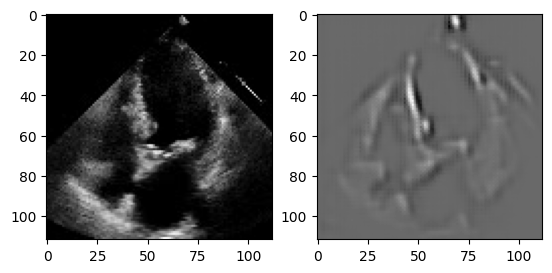

In [71]:
%matplotlib inline

plt.figure(figsize=(10,10))
duration = 32
 
# matplot subplot
fig, ax = plt.subplots(1,2)
 
# method to get frames
def make_frame(t):
    t = t*2
    # clear
    ax[0].clear()
    ax[1].clear()
     
    # plotting line
    ax[0].imshow(input[0,int(t),:,:], cmap = 'gray')
    ax[1].imshow(x[0,int(t),:,:], cmap = 'gray')
     
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
 
# displaying animation with auto play and looping
animation.ipython_display(fps = 2, loop = True, autoplay = True)